In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [60]:
train = pd.read_csv('/Users/lumanzhan/downloads/data/train.csv')
test = pd.read_csv('/Users/lumanzhan/downloads/data/test.csv')

In [61]:
print("=== Dataset Overview ===")
print(train.head())
print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")

=== Dataset Overview ===
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePric

In [62]:
print("=== Dataset Info ===")
print(train.info())
print("\n=== Missing Values Summary ===")
missing_counts = train.isnull().sum()
missing_percent = (missing_counts / len(train)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False))

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   

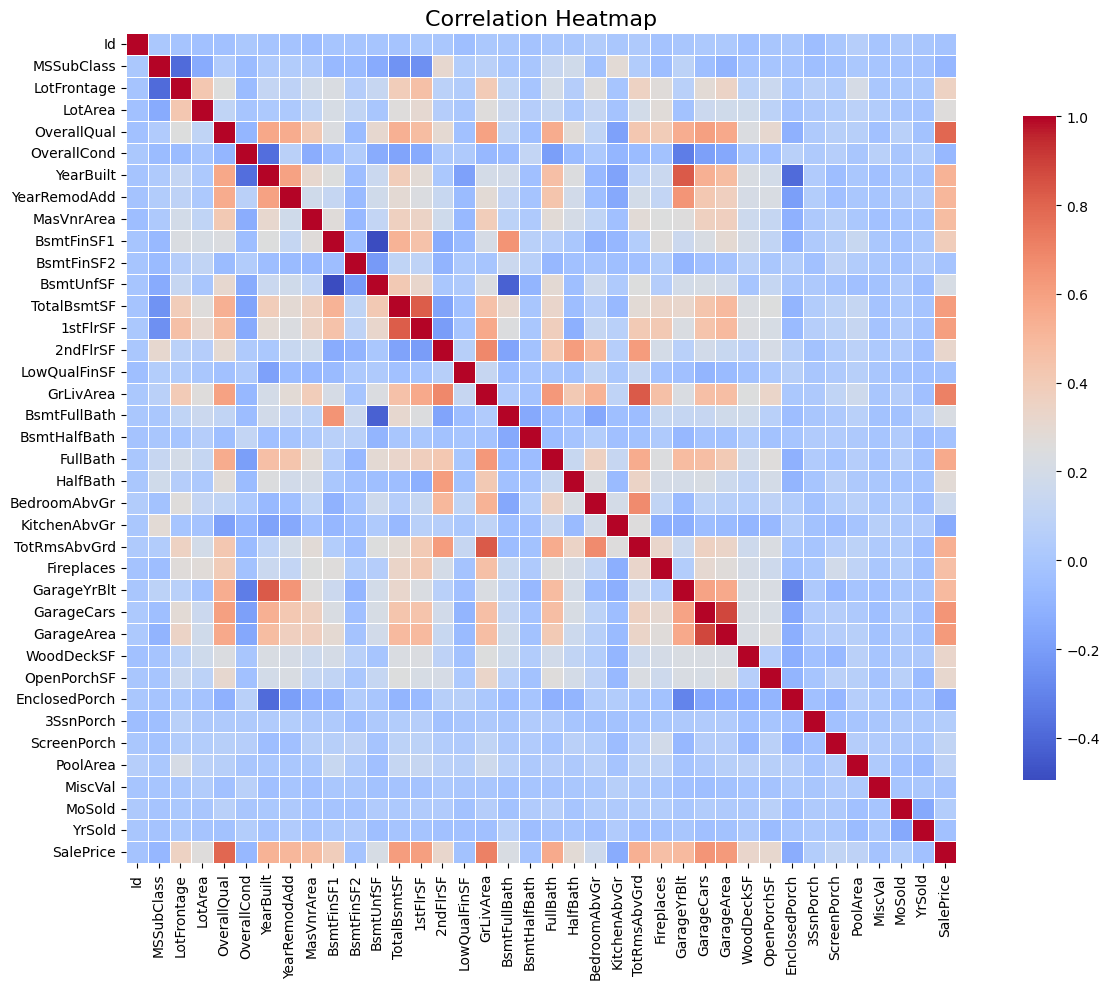

Correlation heatmap saved


In [63]:
correlation_matrix = train.corr(numeric_only=True)

# Visualize correlation
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', 
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
os.makedirs('/Users/lumanzhan/Downloads/data/plots', exist_ok=True)
plt.savefig('/Users/lumanzhan/Downloads/data/plots/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print("Correlation heatmap saved")

In [64]:
# Set correlation threshold
threshold = 0.7

# Create a mask for absolute correlations above threshold
high_corr = correlation_matrix.abs() > threshold

# Extract correlated pairs (excluding self-correlations)
correlated_pairs = []
seen_pairs = set()

for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if col != idx and high_corr.loc[idx, col]:
            # Avoid duplicates (A,B) == (B,A)
            pair = tuple(sorted([idx, col]))
            if pair not in seen_pairs:
                seen_pairs.add(pair)
                correlated_pairs.append((idx, col, correlation_matrix.loc[idx, col]))

# Convert to DataFrame for easier viewing
corr_df = pd.DataFrame(correlated_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
corr_df = corr_df.sort_values(by="Correlation", ascending=False)

print("\n===== Highly Correlated Feature Pairs (|corr| > 0.7) =====")
print(corr_df)

# Identify features to remove (remove the second feature from each pair)
features_to_remove = set()
for _, row in corr_df.iterrows():
    # Remove the second feature to reduce multicollinearity
    features_to_remove.add(row['Feature 2'])

print(f"\nFeatures to remove due to high correlation: {sorted(features_to_remove)}")


===== Highly Correlated Feature Pairs (|corr| > 0.7) =====
      Feature 1    Feature 2  Correlation
5    GarageArea   GarageCars     0.882475
1   GarageYrBlt    YearBuilt     0.825667
3  TotRmsAbvGrd    GrLivArea     0.825489
2      1stFlrSF  TotalBsmtSF     0.819530
0     SalePrice  OverallQual     0.790982
4     SalePrice    GrLivArea     0.708624

Features to remove due to high correlation: ['GarageCars', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']


## Correlation Analysis Summary

We identified highly correlated feature pairs (|correlation| > 0.7) to reduce multicollinearity. 
The features identified for removal will be dropped in the data cleaning step.

In [65]:
# Outlier Detection using IQR method (consistent approach)
def detect_outliers_iqr(df, columns, verbose=False):
    """Detect outliers using IQR method"""
    outlier_info = {}
    for col in columns:
        if col not in df.columns:
            continue
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        mask = (df[col] < low) | (df[col] > high)
        n = mask.sum()
        if verbose and n > 0:
            print(f"[Outlier] {col}: {n} outliers (IQR = [{low:.2f}, {high:.2f}])")
        outlier_info[col] = {'count': n, 'low': low, 'high': high}
    return outlier_info

# Check outliers in key numeric columns
key_numeric_cols = ['SalePrice', 'LotArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']
outlier_info = detect_outliers_iqr(train, key_numeric_cols, verbose=True)

[Outlier] SalePrice: 61 outliers (IQR = [3937.50, 340037.50])
[Outlier] LotArea: 69 outliers (IQR = [1481.50, 17673.50])
[Outlier] GrLivArea: 31 outliers (IQR = [158.62, 2747.62])
[Outlier] TotalBsmtSF: 61 outliers (IQR = [42.00, 2052.00])
[Outlier] 1stFlrSF: 20 outliers (IQR = [118.12, 2155.12])


In [66]:
# ============================================================================
# CRITICAL FIX - Split Data FIRST (before any target-based feature engineering)
# ============================================================================
# Split early to prevent data leakage
X_full = train.drop(columns=['SalePrice', 'Id'], errors='ignore')
y_full = train['SalePrice']

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, 
    test_size=0.3, 
    random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# Combine X and y for easier processing
train_df = X_train.copy()
train_df['SalePrice'] = y_train.values

val_df = X_val.copy()
val_df['SalePrice'] = y_val.values

Training set: 1022 samples
Validation set: 438 samples


In [67]:
# Data Cleaning - Remove High Null Columns
def remove_high_null_columns(df, threshold=0.4):
    """Remove columns with more than threshold% missing values"""
    null_rate = df.isna().mean()
    high_null_cols = null_rate[null_rate > threshold].index.tolist()
    df_clean = df.drop(columns=high_null_cols, errors='ignore')
    if high_null_cols:
        print(f"Removed high-null columns (>{(threshold*100):.0f}% missing): {high_null_cols}")
    return df_clean, high_null_cols

# Apply to training data
train_df, removed_cols = remove_high_null_columns(train_df, threshold=0.4)
# Apply same columns removal to validation
val_df = val_df.drop(columns=removed_cols, errors='ignore')

print(f"Train shape after removing high-null columns: {train_df.shape}")
print(f"Val shape after removing high-null columns: {val_df.shape}")

Removed high-null columns (>40% missing): ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
Train shape after removing high-null columns: (1022, 74)
Val shape after removing high-null columns: (438, 74)


In [68]:
# Data Cleaning - Remove Highly Correlated Features
train_df = train_df.drop(columns=list(features_to_remove), errors='ignore')
val_df = val_df.drop(columns=list(features_to_remove), errors='ignore')

print(f"Train shape after removing correlated features: {train_df.shape}")
print(f"Val shape after removing correlated features: {val_df.shape}")

Train shape after removing correlated features: (1022, 69)
Val shape after removing correlated features: (438, 69)


In [69]:
# Data Cleaning - Remove Outliers (on training set only)
def remove_outliers_iqr(df, columns):
    """Remove outliers using IQR method"""
    df_clean = df.copy()
    initial_rows = len(df_clean)
    
    for col in columns:
        if col not in df_clean.columns:
            continue
        q1 = df_clean[col].quantile(0.25)
        q3 = df_clean[col].quantile(0.75)
        iqr = q3 - q1
        low = q1 - 1.5 * iqr
        high = q3 + 1.5 * iqr
        mask = (df_clean[col] >= low) & (df_clean[col] <= high)
        df_clean = df_clean.loc[mask]
    
    removed = initial_rows - len(df_clean)
    if removed > 0:
        print(f"Removed {removed} outlier rows ({removed/initial_rows*100:.1f}%)")
    return df_clean

# Remove outliers only from training set
candidate_outlier_cols = [c for c in ["SalePrice", "LotArea", "GrLivArea", "TotalBsmtSF"] 
                         if c in train_df.columns]
train_df = remove_outliers_iqr(train_df, candidate_outlier_cols)
print(f"Train shape after outlier removal: {train_df.shape}")

Removed 91 outlier rows (8.9%)
Train shape after outlier removal: (931, 69)


In [70]:
# Data Cleaning - Impute Missing Values (fit on train, transform on val)
def impute_missing_values(train_df, val_df):
    """Impute missing values: fit on train, transform on train and val"""
    train_clean = train_df.copy()
    val_clean = val_df.copy()
    
    # Separate numeric and categorical columns
    num_cols = train_clean.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != 'SalePrice']  # Exclude target
    
    cat_cols = [c for c in train_clean.columns 
                if c not in num_cols and c != 'SalePrice']
    
    # Impute numeric columns
    if num_cols:
        num_imputer = SimpleImputer(strategy="median")
        train_clean[num_cols] = num_imputer.fit_transform(train_clean[num_cols])
        val_clean[num_cols] = num_imputer.transform(val_clean[num_cols])
        print(f"Imputed {len(num_cols)} numeric columns with median")
    
    # Impute categorical columns
    if cat_cols:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        train_clean[cat_cols] = cat_imputer.fit_transform(train_clean[cat_cols])
        val_clean[cat_cols] = cat_imputer.transform(val_clean[cat_cols])
        print(f"Imputed {len(cat_cols)} categorical columns with mode")
    
    return train_clean, val_clean

train_df, val_df = impute_missing_values(train_df, val_df)
print(f"Train missing: {train_df.isnull().sum().sum()}")
print(f"Val missing: {val_df.isnull().sum().sum()}")

Imputed 31 numeric columns with median
Imputed 37 categorical columns with mode
Train missing: 0
Val missing: 0


In [71]:
# Data Cleaning - Text Normalization
def normalize_text(s):
    if pd.isna(s):
        return s
    if not isinstance(s, str):
        return s
    return " ".join(s.strip().lower().split())

cat_cols = [c for c in train_df.columns 
            if train_df[c].dtype == 'object']
for c in cat_cols:
    if c in train_df.columns:
        train_df[c] = train_df[c].apply(normalize_text)
        val_df[c] = val_df[c].apply(normalize_text)

print(f"Normalized {len(cat_cols)} categorical columns")

Normalized 37 categorical columns


In [72]:
# Data Cleaning - Remove Low Variance Columns
def remove_low_variance_columns(df, threshold=0.005):
    """Remove columns with very low variance"""
    n = len(df)
    lv_cols = []
    for c in df.columns:
        if c == 'SalePrice':
            continue
        u = df[c].nunique()
        if (u / max(n, 1)) < threshold:
            lv_cols.append(c)
    df_clean = df.drop(columns=lv_cols, errors='ignore')
    if lv_cols:
        print(f"Removed low variance columns: {lv_cols}")
    return df_clean, lv_cols

train_df, lv_cols = remove_low_variance_columns(train_df)
val_df = val_df.drop(columns=lv_cols, errors='ignore')
print(f"Train shape after low variance removal: {train_df.shape}")

Removed low variance columns: ['Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'Condition2', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'KitchenQual', 'Fireplaces', 'GarageFinish', 'PavedDrive', 'PoolArea']
Train shape after low variance removal: (931, 47)


## Feature Engineering

In [73]:
# Feature Engineering - Consolidated (all in one place)
def engineer_features(df):
    """Create all derived features in one function"""
    df_fe = df.copy()
    
    # Age features
    if all(c in df_fe.columns for c in ["YearBuilt", "YrSold"]):
        df_fe["house_age"] = df_fe["YrSold"] - df_fe["YearBuilt"]
    
    if all(c in df_fe.columns for c in ["YearRemodAdd", "YrSold"]):
        df_fe["remod_age"] = df_fe["YrSold"] - df_fe["YearRemodAdd"]
    
    # Total finished basement square footage
    if all(c in df_fe.columns for c in ["BsmtFinSF1", "BsmtFinSF2"]):
        df_fe["total_BsmtFin_sqft"] = df_fe["BsmtFinSF1"] + df_fe["BsmtFinSF2"]
    
    # Total square footage (above and below grade)
    sqft_cols = ["GrLivArea", "TotalBsmtSF"]
    if all(c in df_fe.columns for c in sqft_cols):
        df_fe["total_sqft"] = df_fe[sqft_cols].sum(axis=1)
    
    # Alternative total square footage calculation
    alt_sqft_cols = ["GrLivArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF"]
    comp_cols = [c for c in alt_sqft_cols if c in df_fe.columns]
    if len(comp_cols) >= 2:
        df_fe["total_sf"] = df_fe[comp_cols].sum(axis=1)
    
    return df_fe

train_df = engineer_features(train_df)
val_df = engineer_features(val_df)
print(f"Train shape after feature engineering: {train_df.shape}")
print(f"Val shape after feature engineering: {val_df.shape}")

Train shape after feature engineering: (931, 50)
Val shape after feature engineering: (438, 50)


In [74]:
# Feature Engineering - Data Integration (FIXED - no data leakage)
def integrate_neighborhood_price(train_df, val_df):
    """Create neighborhood income proxy using ONLY training data"""
    # Compute on training data only
    income_proxy = (
        train_df.groupby("Neighborhood")["SalePrice"]
        .median()
        .reset_index()
        .rename(columns={"SalePrice": "neighborhood_income_proxy"})
    )
    
    # Merge to both train and val
    train_df = train_df.merge(income_proxy, on="Neighborhood", how="left")
    val_df = val_df.merge(income_proxy, on="Neighborhood", how="left")
    
    # Fill any missing values in val (neighborhoods not in train)
    if "neighborhood_income_proxy" in val_df.columns:
        val_df["neighborhood_income_proxy"].fillna(
            train_df["neighborhood_income_proxy"].median(), 
            inplace=True
        )
    
    return train_df, val_df

if "Neighborhood" in train_df.columns and "SalePrice" in train_df.columns:
    train_df, val_df = integrate_neighborhood_price(train_df, val_df)
    print("Integrated neighborhood_income_proxy (computed on train only)")
    print(f"Train shape: {train_df.shape}, Val shape: {val_df.shape}")

Integrated neighborhood_income_proxy (computed on train only)
Train shape: (931, 51), Val shape: (438, 51)


## Data Preprocessing Summary

In [75]:
# Save Cleaned Data (before scaling)
os.makedirs("data", exist_ok=True)
train_df.to_csv('/Users/lumanzhan/downloads/data/cleaned_train.csv', index=False)
val_df.to_csv('/Users/lumanzhan/downloads/data/cleaned_val.csv', index=False)
print(f"Cleaned data saved | Train: {train_df.shape}, Val: {val_df.shape}")

Cleaned data saved | Train: (931, 51), Val: (438, 51)


## Scaling and Model Training

In [76]:
# Prepare Features and Target
# Separate features and target
X_train = train_df.drop(columns=['SalePrice'], errors='ignore')
y_train = train_df['SalePrice']
X_val = val_df.drop(columns=['SalePrice'], errors='ignore')
y_val = val_df['SalePrice']

# Select numeric columns for scaling (exclude target and ID if present)
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['Id']]

# Select categorical columns
cat_cols = [c for c in X_train.columns if c not in num_cols]

print(f"Numeric features: {len(num_cols)}")
print(f"Categorical features: {len(cat_cols)}")
print(f"Total features: {len(X_train.columns)}")

Numeric features: 28
Categorical features: 22
Total features: 50


## Model Training and Evaluation

In [77]:
# CRITICAL FIX - Scaling (AFTER split, fit on train only)
# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])

# Transform validation data using scaler fitted on training data
X_val_scaled = X_val.copy()
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])

# Save standardized data
X_train_scaled['SalePrice'] = y_train.values
X_val_scaled['SalePrice'] = y_val.values

os.makedirs('/Users/lumanzhan/Downloads/data', exist_ok=True)
X_train_scaled.to_csv('/Users/lumanzhan/Downloads/data/standardized_train.csv', index=False)
X_val_scaled.to_csv('/Users/lumanzhan/Downloads/data/standardized_val.csv', index=False)

print("Scaling completed (fitted on train, applied to train and val)")
print(f"Train scaled shape: {X_train_scaled.shape}")
print(f"Val scaled shape: {X_val_scaled.shape}")


Scaling completed (fitted on train, applied to train and val)
Train scaled shape: (931, 51)
Val scaled shape: (438, 51)


## Model Training - Baseline

In [78]:
# Optional - PCA Analysis (for visualization, not used in modeling)
def analyze_pca(X_train_scaled, X_val_scaled, num_cols, n_components=0.95):
    """Perform PCA analysis for visualization"""
    X_train_pca = X_train_scaled[num_cols].copy()
    X_val_pca = X_val_scaled[num_cols].copy()
    
    # PCA
    pca = PCA(n_components=n_components, svd_solver="full", random_state=42)
    X_train_pca_transformed = pca.fit_transform(X_train_pca)
    X_val_pca_transformed = pca.transform(X_val_pca)
    
    # Explained variance
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = X_train_pca_transformed.shape[1]
    
    print(f"PCA components: {n_comp}")
    print(f"Cumulative variance explained: {(cum_var[-1] * 100):.1f}%")
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o')
    plt.axhline(n_components, linestyle='--', color='r', label=f'{n_components*100}% threshold')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title("PCA - Cumulative Explained Variance")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    os.makedirs('/Users/lumanzhan/Downloads/data/plots', exist_ok=True)
    plt.savefig('/Users/lumanzhan/Downloads/data/plots/pca_cum_var.png', dpi=150, bbox_inches='tight')
    plt.close()
    
    return X_train_pca_transformed, X_val_pca_transformed, pca

# Run PCA analysis
X_train_pca, X_val_pca, pca_model = analyze_pca(X_train_scaled, X_val_scaled, num_cols)
print("PCA analysis completed")

PCA components: 20
Cumulative variance explained: 95.5%
PCA analysis completed


## Hyperparameter Tuning

In [79]:
# Model Evaluation - Visualizations
# Residual plot and Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
axes[0].scatter(y_val_pred, y_val - y_val_pred, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Sale Price')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residual Plot (Validation)')
axes[0].grid(True, alpha=0.3)

# Actual vs Predicted
axes[1].scatter(y_val, y_val_pred, alpha=0.5)
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
axes[1].set_xlabel('Actual Sale Price')
axes[1].set_ylabel('Predicted Sale Price')
axes[1].set_title('Actual vs Predicted (Validation)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs('/Users/lumanzhan/Downloads/data/plots', exist_ok=True)
plt.savefig('/Users/lumanzhan/Downloads/data/plots/model_evaluation.png', dpi=150, bbox_inches='tight')
plt.close()

print("Evaluation plots saved")


Evaluation plots saved


In [80]:
# Hyperparameter Tuning - Ridge Regression
# Hyperparameter tuning with cross-validation
param_grid = {
    'alpha': [0.1, 1, 10, 50, 100, 200, 500]
}

ridge_model = Ridge()

grid_search = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Tuning Ridge Regression...")
grid_search.fit(X_train_model, y_train)

print(f"\nBest Alpha: {grid_search.best_params_['alpha']}")
print(f"Best CV Score (neg_RMSE): {grid_search.best_score_:.2f}")

# Evaluate best model on validation set
best_model = grid_search.best_estimator_
y_val_pred_tuned = best_model.predict(X_val_model)

val_metrics_tuned = evaluate_model(y_val, y_val_pred_tuned, "Validation (Tuned)")

# Compare with baseline
print(f"\nImprovement:")
print(f"  Baseline RMSE: ${val_metrics['RMSE']:,.2f}")
print(f"  Tuned RMSE:    ${val_metrics_tuned['RMSE']:,.2f}")
print(f"  Improvement:   ${val_metrics['RMSE'] - val_metrics_tuned['RMSE']:,.2f}")


Tuning Ridge Regression...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

Best Alpha: 10
Best CV Score (neg_RMSE): -23007.21

Validation (Tuned) Metrics:
  RMSE: $34,961.82
  MAE:  $20,835.88
  R²:   0.8248

Improvement:
  Baseline RMSE: $34,838.12
  Tuned RMSE:    $34,961.82
  Improvement:   $-123.69


In [81]:
# Feature Importance (for Ridge - coefficients)
# Get feature importance from best model
feature_importance = pd.DataFrame({
    'Feature': features_to_use,
    'Coefficient': best_model.coef_,
    'Abs_Coefficient': np.abs(best_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance.head(15))

# Visualize
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Abs_Coefficient'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Feature Importance (Ridge Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()

os.makedirs('/Users/lumanzhan/Downloads/data/plots', exist_ok=True)
plt.savefig('/Users/lumanzhan/Downloads/data/plots/feature_importance.png', dpi=150, bbox_inches='tight')
plt.close()
print("Feature importance plot saved")



Top 15 Most Important Features:
                      Feature   Coefficient  Abs_Coefficient
27  neighborhood_income_proxy  16941.519913     16941.519913
26                   total_sf  14839.420055     14839.420055
8                   BsmtUnfSF  11451.266938     11451.266938
10                   2ndFlrSF  10974.493830     10974.493830
6                  BsmtFinSF1   8656.240664      8656.240664
25         total_BsmtFin_sqft   8587.816746      8587.816746
15                 GarageArea   6155.576628      6155.576628
9                    1stFlrSF   5975.375705      5975.375705
12               BedroomAbvGr  -5871.113533      5871.113533
3                 OverallCond   4868.077723      4868.077723
14                GarageYrBlt   4363.733223      4363.733223
2                     LotArea   3701.385678      3701.385678
24                  remod_age  -3557.947031      3557.947031
4                YearRemodAdd   3552.699437      3552.699437
0                  MSSubClass  -3091.182352      309

In [82]:
# Model Training - Baseline (using all numeric features)
# Use all numeric features (or select specific ones)
# Option 1: Use all numeric features
features_to_use = num_cols

# Option 2: Use specific features (uncomment to use)
# features_to_use = ['GrLivArea', 'BedroomAbvGr', 'OverallQual', 'TotalBsmtSF']

X_train_model = X_train_scaled[features_to_use]
X_val_model = X_val_scaled[features_to_use]

print(f"Using {len(features_to_use)} features for modeling")
if len(features_to_use) > 10:
    print(f"Features (first 10): {features_to_use[:10]}")
else:
    print(f"Features: {features_to_use}")

# Train baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train_model, y_train)

# Predictions
y_train_pred = baseline_model.predict(X_train_model)
y_val_pred = baseline_model.predict(X_val_model)

# Evaluation metrics
def evaluate_model(y_true, y_pred, dataset_name=""):
    """Calculate multiple evaluation metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = evaluate_model(y_train, y_train_pred, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")

Using 28 features for modeling
Features (first 10): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF']

Training Metrics:
  RMSE: $22,200.87
  MAE:  $16,408.69
  R²:   0.8561

Validation Metrics:
  RMSE: $34,838.12
  MAE:  $20,835.04
  R²:   0.8261
